In [1]:
import nrrd
import os
import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import csv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model
from matplotlib.colors import ListedColormap
import Segment_support_lib

In [2]:
crop_ankle_train = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Ankle'
crop_mask_train = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\train\\Mask'
crop_ankle_test = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\test\\Ankle'
crop_mask_test = 'F:\\Birva_Harsh\\Ankle_Crop_Data\\test\\Mask'

In [3]:
ankle_train = [os.path.join(crop_ankle_train, i) for i in os.listdir(crop_ankle_train)]
mask_train = [path.replace('\\Ankle\\', '\\Mask\\') for path in ankle_train]

ankle_test = [os.path.join(crop_ankle_test, i) for i in os.listdir(crop_ankle_test)]
mask_test = [path.replace('\\Ankle\\', '\\Mask\\') for path in ankle_test]

In [4]:
df_train = pd.DataFrame( data = {
    'ankle': ankle_train,
    'mask': mask_train
})

df_test = pd.DataFrame( data = {
    'ankle': ankle_test,
    'mask': mask_test
})

In [5]:
def load_and_preprocess_image(file_path,resize):
    img,info = nrrd.read(file_path)
    if resize == 128:
        img = img[::2,::2,::2]
    img = np.clip(img, a_min=-1024, a_max=None)
    img = img[:,:,:,np.newaxis]   
    img_scaled = img.astype(np.float32) / 1024.0
    return img_scaled

In [6]:
def load_and_preprocess_mask(mask_path,img_path,resize):
    img,hinfo = nrrd.read(img_path)
    mask,minfo = nrrd.read(mask_path)
    
    if resize == 128:
        img = img[::2,::2,::2]
        mask = mask[::2,::2,::2]
    mask = np.where(mask==3,1,0)   
    thres = np.where(img < 200, 0, 1)
    res = thres-mask
    res = np.where(res<=0,0,1)
    
    mask_merge = np.stack((mask,res), axis=-1)
    mask_merge = mask_merge.astype(np.float32)
    
    return mask_merge

In [7]:
def dice_coeff(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coeff_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coeff(y_true, y_pred, smooth)

In [8]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice    

In [9]:
model = tf.keras.models.load_model("F:\\Birva_Harsh\\Ankle_models\\pocketnet_256_16.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})

In [10]:
def ankle_split_array(pred_mask):
   
    m1 = pred_mask[:,:,:,:,0]
    m2 = pred_mask[:,:,:,:,1]
    
    max_values = np.maximum(m1, m2)
    m1[m1 < 0.5] = 0
    m2[m2 < 0.5] = 0
    
    mask1 = (m1 == max_values)
    mask2 = (m2 == max_values)
    
    p1 = (np.where(mask1, m1, 0)>=0.5).astype(np.uint8)
    p2 = (np.where(mask2, m2, 0)>=0.5).astype(np.uint8)
    
    p1 = np.where(p1 == 1,1,0)
    p2 = np.where(p2 == 1,5,0)

    return p1,p2

In [11]:
def plot_3d(model,img_path,mask_path,resize):
    colors = ['black', 'red', 'lime']
    
    #cmap = ListedColormap(colors)
    #norm = plt.cm.colors.Normalize(vmin=0, vmax=4)
    
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    #pred_mask = model.predict(img)
    
    mask = load_and_preprocess_mask(mask_path,img_path,resize)
    mask = mask[np.newaxis,:,:,:,:]
    
    img = np.squeeze(img)
    
    
    tibia, ankle = ankle_split_array(mask)
    mask = np.squeeze(mask)
    pred_m = tibia+ankle
    pred_m = np.squeeze(pred_m)
    #Segment_support_lib.get_3D_mesh(np.squeeze(femur),None,'femur')
    #Segment_support_lib.get_3D_mesh(np.squeeze(patella),None,'pelvic')
    
    #pred_m = femur+pelvic
    #pred_m = np.squeeze(pred_m)
    #print(np.unique(femur))
    plt.figure(figsize=(18,12))
    plt.subplot(3, 3, 1)
    plt.imshow(img[resize//2,:,:].T,cmap='gray')
    plt.axis('off')
    plt.title("X")
    
    plt.subplot(3, 3, 2)
    plt.imshow(img[:,resize//2,:].T,cmap='gray')
    plt.axis('off')
    plt.title("Y")
    
    plt.subplot(3, 3, 3)
    plt.imshow(img[:,:,resize//2].T,cmap='gray')
    plt.axis('off')
    plt.title("Z")
    
    
    plt.subplot(3, 3, 4)
    plt.imshow(pred_m[resize//2,:,:].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask X")
    
    plt.subplot(3, 3, 5)
    plt.imshow(pred_m[:,resize//2,:].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask Y")
    
    plt.subplot(3, 3, 6)
    plt.imshow(pred_m[:,:,resize//2].T,interpolation='nearest')
    plt.axis('off')
    plt.title("Mask Z")
    
    # plt.subplot(3, 3, 7)
    # plt.imshow(pred_m[resize//2,:,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    # plt.axis('off')
    # plt.title("Pred Mask X")
    
    # plt.subplot(3, 3, 8)
    # plt.imshow(pred_m[:,resize//2,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    # plt.axis('off')
    # plt.title("Pred Mask Y")
    
    # plt.subplot(3, 3, 9)
    # plt.imshow(pred_m[:,:,resize//2].T,interpolation='nearest',cmap=cmap,norm=norm)
    # plt.axis('off')
    # plt.title("Pred Mask Z")
plt.show()

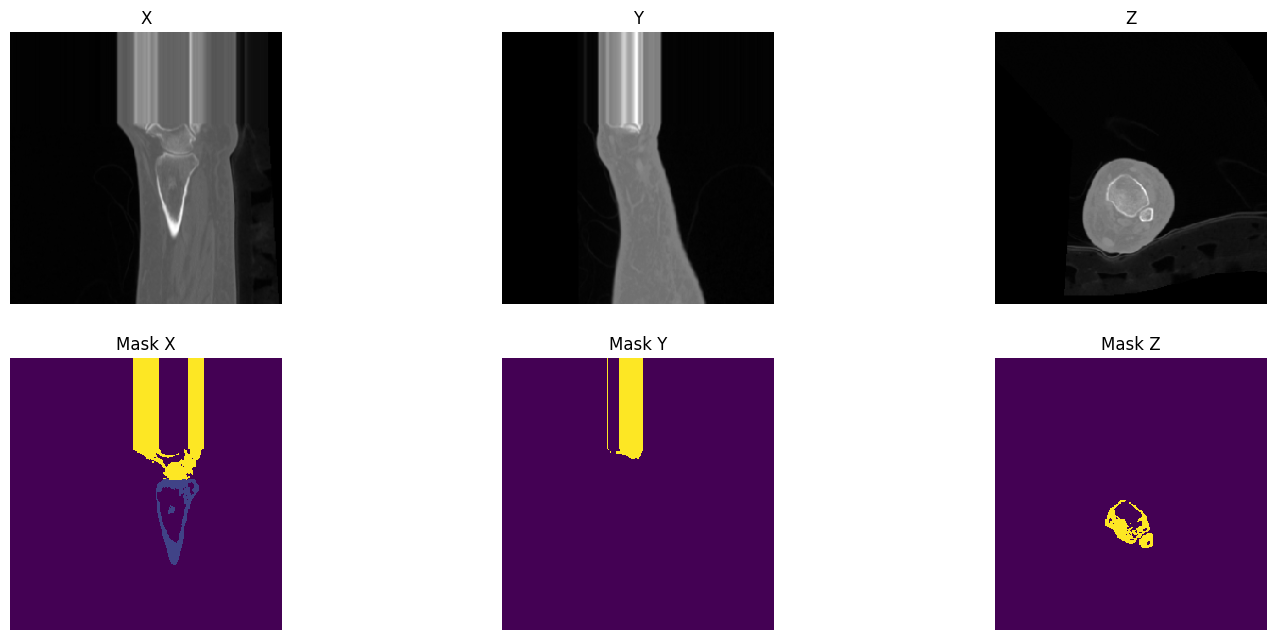

In [12]:
plot_3d(model,df_test.loc[0,'ankle'],df_test.loc[0,'mask'],256)

In [13]:
def mesh_3d(model,img_path,mask_path,resize):
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    mask = load_and_preprocess_mask(mask_path,img_path,resize)
    
    img = np.squeeze(img)
    mask = np.squeeze(mask)
    
    tibia, ankle = ankle_split_array(pred_mask)
    patient_name = os.path.basename(img_path).split('.')[0]
    
    base_path = f'F:\\Birva_Harsh\\3D segmentation\\Ankle\\{patient_name}'
    os.makedirs(base_path, exist_ok=True)
    
    tibia_path = f'F:\\Birva_Harsh\\3D segmentation\\Ankle\\{patient_name}\\tibia'
    ankle_path = f'F:\\Birva_Harsh\\3D segmentation\\Ankle\\{patient_name}\\ankle'
    
    Segment_support_lib.get_3D_mesh(np.squeeze(tibia),None,tibia_path)
    Segment_support_lib.get_3D_mesh(np.squeeze(ankle),None,ankle_path)
    
    stl_files = [
        tibia_path+'.stl',
        ankle_path+'.stl'  
    ]
    colors = [
    [1.0, 0.0, 0.0],  
    [0.0, 0.0, 1.0]   
]
    combined_file = f'F:\\Birva_Harsh\\3D segmentation\\Ankle\\{patient_name}\\combined.stl'
    Segment_support_lib.combine_stl_files(stl_files,combined_file,colors)

In [14]:
for i in df_test.index:
    mesh_3d(model,df_test.loc[i,'ankle'],df_test.loc[i,'mask'],256)

1/1 [==============================] - 0s 28ms/step
